In [1]:
# %pip install torch optuna seaborn

In [2]:
import optuna
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('data.csv', encoding='ISO-8859-1')  # Lectura de caracteres o signos especiales del espanol


C:\Users\Ibrahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701083 entries, 0 to 701082
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dia                 701083 non-null  object 
 1   Hora                701083 non-null  object 
 2   Latitud Central     701083 non-null  float64
 3   Longitud Central    701083 non-null  float64
 4   Tipo de Via         701083 non-null  object 
 5   Congestion          701083 non-null  object 
 6   Congestion_Numeric  701083 non-null  int64  
 7   Distance            701083 non-null  float64
 8   Duration            701083 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 48.1+ MB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitud Central,701083.0,-12.123855,0.045094,-12.225161,-12.159201,-12.111800,-12.086533,-12.051969
Longitud Central,701083.0,-77.018400,0.031615,-77.110631,-77.034910,-77.014755,-76.994466,-76.953908
Congestion_Numeric,701083.0,3.983951,9.269304,-1.000000,-1.000000,0.000000,4.000000,91.000000
Distance,701083.0,42.452196,42.411308,0.000000,10.800000,27.100000,61.700000,726.300000
Duration,701083.0,7.929850,8.110030,0.000000,2.113000,5.172000,11.227500,165.029000


In [5]:
data.head()

,Dia,Hora,Latitud Central,Longitud Central,Tipo de Via,Congestion,Congestion_Numeric,Distance,Duration
0,Sunday,20:20,-12.218011,-76.977544,carretera panamericana sur,unknown,-1,7.8,1.846
1,Sunday,20:20,-12.219672,-76.976457,carretera panamericana sur,low,0,19.3,0.722
2,Sunday,20:20,-12.220101,-76.975983,carretera panamericana sur,low,17,17.7,5.536
3,Sunday,20:20,-12.214297,-76.982415,avenida caminos del inca,low,0,19.1,1.723
4,Sunday,20:20,-12.217824,-76.978839,avenida caminos del inca,unknown,-1,20.9,5.026


In [6]:

# Convertir el día a valores numéricos (label encoding)
label_encoder = LabelEncoder()
data['Dia'] = label_encoder.fit_transform(data['Dia'])
data.head()

,Dia,Hora,Latitud Central,Longitud Central,Tipo de Via,Congestion,Congestion_Numeric,Distance,Duration
0,2,20:20,-12.218011,-76.977544,carretera panamericana sur,unknown,-1,7.8,1.846
1,2,20:20,-12.219672,-76.976457,carretera panamericana sur,low,0,19.3,0.722
2,2,20:20,-12.220101,-76.975983,carretera panamericana sur,low,17,17.7,5.536
3,2,20:20,-12.214297,-76.982415,avenida caminos del inca,low,0,19.1,1.723
4,2,20:20,-12.217824,-76.978839,avenida caminos del inca,unknown,-1,20.9,5.026


In [7]:
# Ver las clases ordenadas por LabelEncoder
print(label_encoder.classes_)

['Friday' 'Monday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


In [8]:
# Convertir la hora a minutos totales desde medianoche
data['Hora'] = pd.to_datetime(data['Hora'], format='%H:%M').dt.hour * 60 + pd.to_datetime(data['Hora'], format='%H:%M').dt.minute
data.head()

,Dia,Hora,Latitud Central,Longitud Central,Tipo de Via,Congestion,Congestion_Numeric,Distance,Duration
0,2,1220,-12.218011,-76.977544,carretera panamericana sur,unknown,-1,7.8,1.846
1,2,1220,-12.219672,-76.976457,carretera panamericana sur,low,0,19.3,0.722
2,2,1220,-12.220101,-76.975983,carretera panamericana sur,low,17,17.7,5.536
3,2,1220,-12.214297,-76.982415,avenida caminos del inca,low,0,19.1,1.723
4,2,1220,-12.217824,-76.978839,avenida caminos del inca,unknown,-1,20.9,5.026


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701083 entries, 0 to 701082
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dia                 701083 non-null  int32  
 1   Hora                701083 non-null  int32  
 2   Latitud Central     701083 non-null  float64
 3   Longitud Central    701083 non-null  float64
 4   Tipo de Via         701083 non-null  object 
 5   Congestion          701083 non-null  object 
 6   Congestion_Numeric  701083 non-null  int64  
 7   Distance            701083 non-null  float64
 8   Duration            701083 non-null  float64
dtypes: float64(4), int32(2), int64(1), object(2)
memory usage: 42.8+ MB


In [10]:
data = data.drop(columns='Congestion', axis=1)
data.head()

,Dia,Hora,Latitud Central,Longitud Central,Tipo de Via,Congestion_Numeric,Distance,Duration
0,2,1220,-12.218011,-76.977544,carretera panamericana sur,-1,7.8,1.846
1,2,1220,-12.219672,-76.976457,carretera panamericana sur,0,19.3,0.722
2,2,1220,-12.220101,-76.975983,carretera panamericana sur,17,17.7,5.536
3,2,1220,-12.214297,-76.982415,avenida caminos del inca,0,19.1,1.723
4,2,1220,-12.217824,-76.978839,avenida caminos del inca,-1,20.9,5.026


In [11]:
df_original = data
df_original.head()

,Dia,Hora,Latitud Central,Longitud Central,Tipo de Via,Congestion_Numeric,Distance,Duration
0,2,1220,-12.218011,-76.977544,carretera panamericana sur,-1,7.8,1.846
1,2,1220,-12.219672,-76.976457,carretera panamericana sur,0,19.3,0.722
2,2,1220,-12.220101,-76.975983,carretera panamericana sur,17,17.7,5.536
3,2,1220,-12.214297,-76.982415,avenida caminos del inca,0,19.1,1.723
4,2,1220,-12.217824,-76.978839,avenida caminos del inca,-1,20.9,5.026


In [12]:
data = data[data['Congestion_Numeric'] != -1]
data.head()

,Dia,Hora,Latitud Central,Longitud Central,Tipo de Via,Congestion_Numeric,Distance,Duration
1,2,1220,-12.219672,-76.976457,carretera panamericana sur,0,19.3,0.722
2,2,1220,-12.220101,-76.975983,carretera panamericana sur,17,17.7,5.536
3,2,1220,-12.214297,-76.982415,avenida caminos del inca,0,19.1,1.723
5,2,1220,-12.219575,-76.977372,avenida caminos del inca,0,7.9,0.682
9,2,1220,-12.216620,-76.980104,motorway_link,0,39.0,2.924


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 408901 entries, 1 to 701082
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dia                 408901 non-null  int32  
 1   Hora                408901 non-null  int32  
 2   Latitud Central     408901 non-null  float64
 3   Longitud Central    408901 non-null  float64
 4   Tipo de Via         408901 non-null  object 
 5   Congestion_Numeric  408901 non-null  int64  
 6   Distance            408901 non-null  float64
 7   Duration            408901 non-null  float64
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 25.0+ MB
None

Primeras filas del dataset:
   Dia  Hora  Latitud Central  Longitud Central                 Tipo de Via  \
1    2  1220       -12.219672        -76.976457  carretera panamericana sur   
2    2  1220       -12.220101        -76.975983  carretera panamericana sur   
3    2  1220      

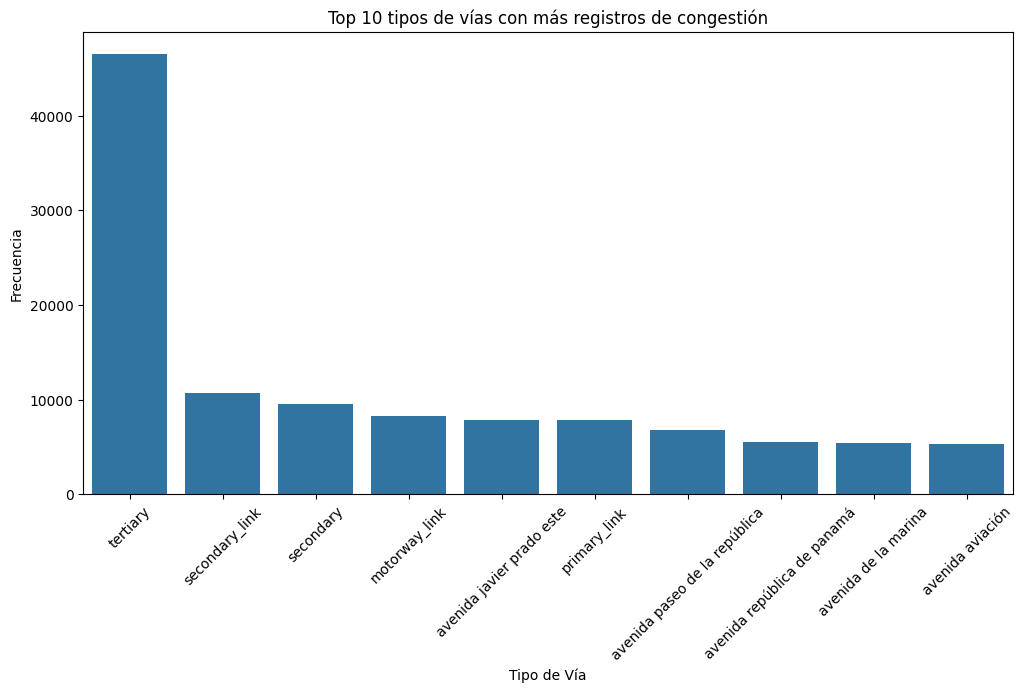

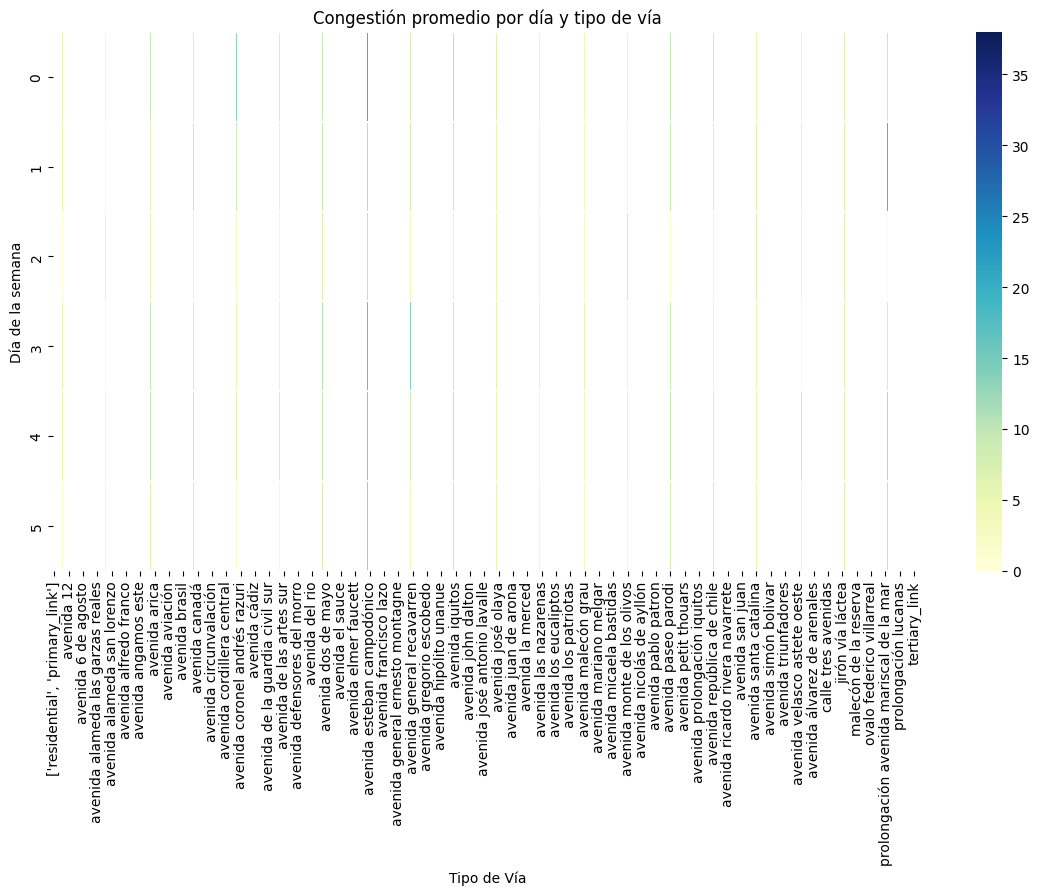

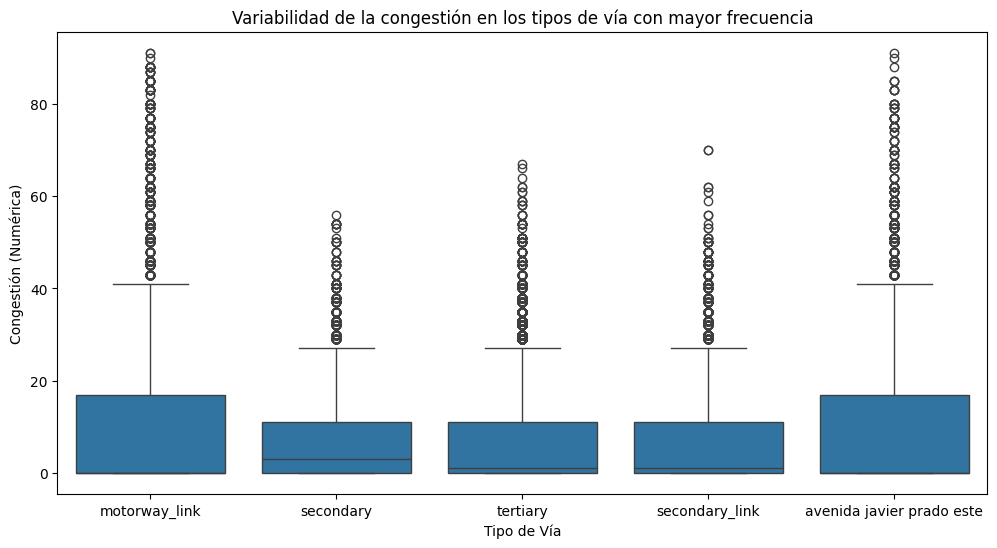

In [13]:
df = data 

print("Información general del dataset:")
print(df.info())
print("\nPrimeras filas del dataset:")
print(df.head())

via_frecuencia = df['Tipo de Via'].value_counts()
print("\nFrecuencia de aparición por tipo de vía:")
print(via_frecuencia.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x=via_frecuencia.head(10).index, y=via_frecuencia.head(10).values)
plt.xticks(rotation=45)
plt.title("Top 10 tipos de vías con más registros de congestión")
plt.xlabel("Tipo de Vía")
plt.ylabel("Frecuencia")
plt.show()

congestion_dia_via = df.groupby(['Dia', 'Tipo de Via'])['Congestion_Numeric'].mean().unstack()

plt.figure(figsize=(14, 7))
sns.heatmap(congestion_dia_via, cmap="YlGnBu", linewidths=0.1)
plt.title("Congestión promedio por día y tipo de vía")
plt.xlabel("Tipo de Vía")
plt.ylabel("Día de la semana")
plt.show()

top_vias = via_frecuencia.head(5).index
df_top_vias = df[df['Tipo de Via'].isin(top_vias)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='Tipo de Via', y='Congestion_Numeric', data=df_top_vias)
plt.title("Variabilidad de la congestión en los tipos de vía con mayor frecuencia")
plt.xlabel("Tipo de Vía")
plt.ylabel("Congestión (Numérica)")
plt.show()


Número de ocurrencias por calle:
Tipo de Via
tertiary                         46496
secondary_link                   10654
secondary                         9551
motorway_link                     8215
avenida javier prado este         7824
primary_link                      7788
avenida paseo de la república     6835
avenida república de panamá       5529
avenida de la marina              5457
avenida aviación                  5278
Name: count, dtype: int64


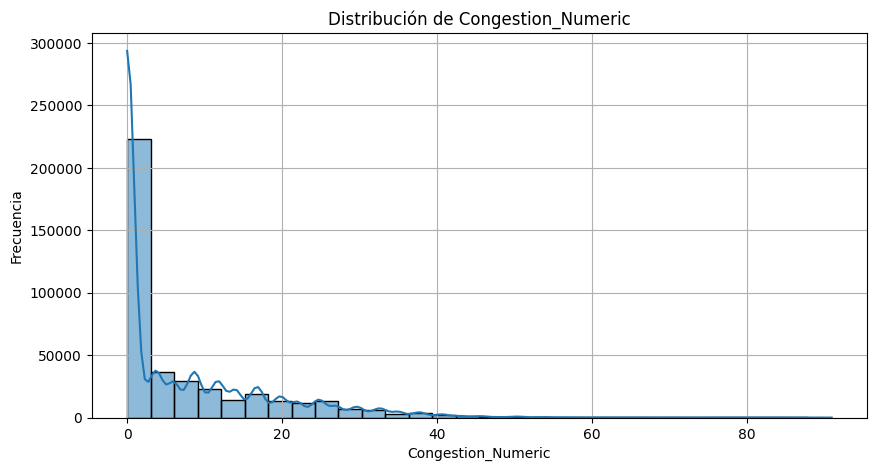


Promedio de Congestion_Numeric por calle (Top 10):
Tipo de Via
avenida los horticultores               26.813953
avenida jorge basadre                   24.604396
avenida oscar de la barrera             20.307692
carretera panamericana sur              18.290076
avenida panamericana sur                17.389944
vía expresa luis fernán bedoya reyes    17.021006
circuito de playas                      15.387384
avenida miraflores                      14.711111
avenida españa                          14.369863
avenida dionisio derteano               14.075000
Name: Congestion_Numeric, dtype: float64


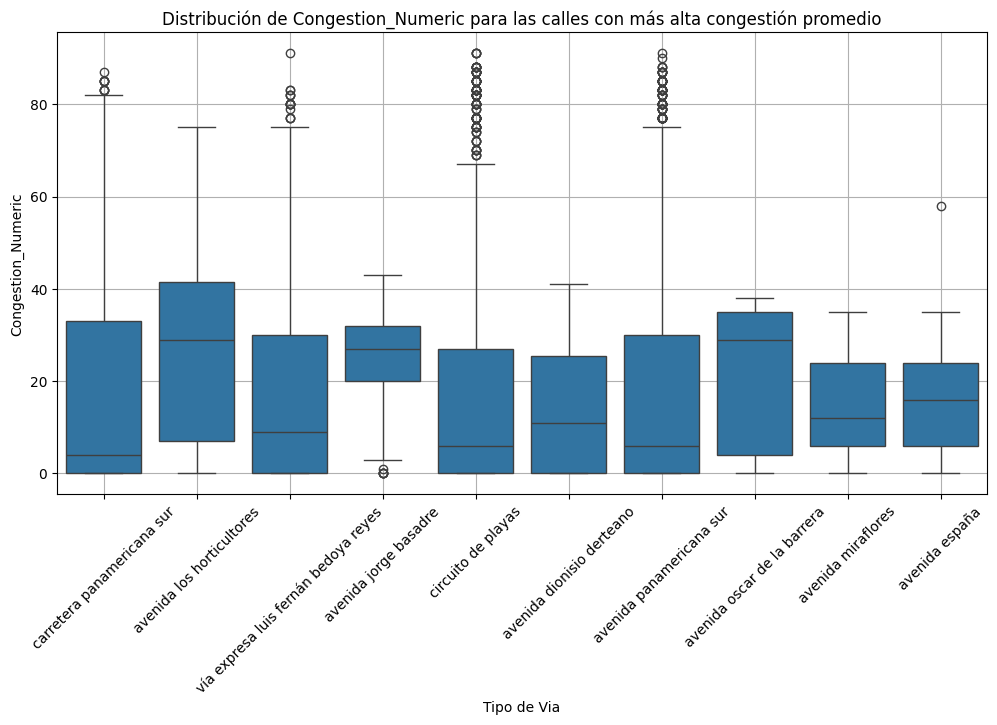


Porcentaje de datos con alta congestión: 36.53%


In [14]:
street_counts = df['Tipo de Via'].value_counts()
print("Número de ocurrencias por calle:")
print(street_counts.head(10))

plt.figure(figsize=(10, 5))
sns.histplot(df['Congestion_Numeric'], bins=30, kde=True)
plt.title("Distribución de Congestion_Numeric")
plt.xlabel("Congestion_Numeric")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

avg_congestion_per_street = df.groupby('Tipo de Via')['Congestion_Numeric'].mean().sort_values(ascending=False)
print("\nPromedio de Congestion_Numeric por calle (Top 10):")
print(avg_congestion_per_street.head(10))

top_congested_streets = avg_congestion_per_street.head(10).index
top_congested_data = df[df['Tipo de Via'].isin(top_congested_streets)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_congested_data, x='Tipo de Via', y='Congestion_Numeric')
plt.xticks(rotation=45)
plt.title("Distribución de Congestion_Numeric para las calles con más alta congestión promedio")
plt.xlabel("Tipo de Via")
plt.ylabel("Congestion_Numeric")
plt.grid(True)
plt.show()

high_congestion = df[df['Congestion_Numeric'] > df['Congestion_Numeric'].mean()]
high_congestion_percentage = (len(high_congestion) / len(df)) * 100
print(f"\nPorcentaje de datos con alta congestión: {high_congestion_percentage:.2f}%")


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408901 entries, 1 to 701082
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dia                 408901 non-null  int32  
 1   Hora                408901 non-null  int32  
 2   Latitud Central     408901 non-null  float64
 3   Longitud Central    408901 non-null  float64
 4   Tipo de Via         408901 non-null  object 
 5   Congestion_Numeric  408901 non-null  int64  
 6   Distance            408901 non-null  float64
 7   Duration            408901 non-null  float64
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 25.0+ MB


In [16]:
calles_principales = [
    'avenida javier prado este', 'avenida javier prado oeste', 'avenida la marina',
    'avenida antonio josé de sucre', 'avenida faustino sanchez carrión','avenida del ejército',
    'ovalo josé quiñones', 'circuito de playas',
    'avenida del parque norte', 'avenida general salaverry', 'avenida la paz',
    'avenida san borja norte', 'avenida lima polo', 'avenida panamericana sur',
    'avenida primavera', 'avenida el derby','avenida angamos este', 'avenida angamos oeste',
    'avenida alfredo benavides'
]

data = data[data['Tipo de Via'].isin(calles_principales)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49421 entries, 973 to 701082
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Dia                 49421 non-null  int32  
 1   Hora                49421 non-null  int32  
 2   Latitud Central     49421 non-null  float64
 3   Longitud Central    49421 non-null  float64
 4   Tipo de Via         49421 non-null  object 
 5   Congestion_Numeric  49421 non-null  int64  
 6   Distance            49421 non-null  float64
 7   Duration            49421 non-null  float64
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 3.0+ MB


In [17]:

X = data[['Dia','Hora','Latitud Central','Longitud Central','Tipo de Via']]
y = data['Congestion_Numeric']

# X = pd.get_dummies(X, columns=['Tipo de Via'])
X = X.drop(columns='Tipo de Via', axis=1)

In [18]:
X.sample()

,Dia,Hora,Latitud Central,Longitud Central
700870,0,1353,-12.125551,-77.023151


In [19]:
X.replace({True: 1, False: 0}, inplace=True)

X.head()

,Dia,Hora,Latitud Central,Longitud Central
973,2,1223,-12.113701,-77.029861
974,2,1223,-12.113170,-77.029878
979,2,1223,-12.124516,-77.029388
980,2,1223,-12.124666,-77.028660
991,2,1223,-12.113740,-77.029938


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42, k_neighbors=1)
X_train, y_train = smote.fit_resample(X_train_resampled, y_train_resampled)

Distribución después de SMOTE en los datos de entrenamiento:
Congestion_Numeric
35    16558
62    16558
29    16558
67    16558
59    16558
83    16558
43    16558
75    16558
51    16558
85    16558
50    16558
40    16558
66    16558
58    16558
80    16558
0     16558
74    16558
54    16558
48    16558
56    16558
72    16558
82    16558
87    16558
77    16558
88    16558
91    16558
70    16558
69    16558
32    16558
46    16558
3     16558
45    16558
64    16558
6     16558
61    16558
25    16558
33    16558
4     16558
9     16558
41    16558
1     16558
8     16558
14    16558
30    16558
79    16558
11    16558
37    16558
53    16558
27    16558
38    16558
22    16558
17    16558
19    16558
12    16558
16    16558
20    16558
24    16558
90    16558
Name: count, dtype: int64


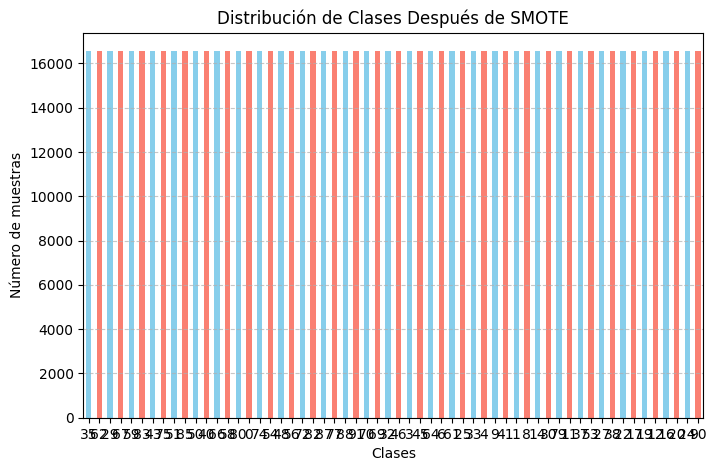

In [21]:
print("Distribución después de SMOTE en los datos de entrenamiento:")
print(y_train.value_counts())

plt.figure(figsize=(8, 5))
y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Clases Después de SMOTE')
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [22]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [23]:
import joblib

# Guardar los escaladores en archivos
joblib.dump(scaler_X, "scaler_X.pkl")  # Guardar escalador para X
joblib.dump(scaler_y, "scaler_y.pkl")  # Guardar escalador para y

print("Escaladores guardados exitosamente.")


Escaladores guardados exitosamente.


In [24]:
X.head()

,Dia,Hora,Latitud Central,Longitud Central
973,2,1223,-12.113701,-77.029861
974,2,1223,-12.113170,-77.029878
979,2,1223,-12.124516,-77.029388
980,2,1223,-12.124666,-77.028660
991,2,1223,-12.113740,-77.029938


In [25]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

class TrafficModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(TrafficModel, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [26]:
import torch
import numpy as np

def reduce_rows(X_train, X_test, y_train, y_test, n_rows=30000):
    test_ratio = len(X_test) / len(X_train)
    n_rows_test = int(n_rows * test_ratio)

    train_indices = torch.randperm(len(X_train))[:n_rows]
    test_indices = torch.randperm(len(X_test))[:n_rows_test]

    X_train_small = X_train[train_indices]
    y_train_small = y_train[train_indices]
    X_test_small = X_test[test_indices]
    y_test_small = y_test[test_indices]

    print(f"Tamaño original del conjunto de entrenamiento: {len(X_train)}")
    print(f"Nuevo tamaño del conjunto de entrenamiento: {len(X_train_small)}")
    print(f"Tamaño original del conjunto de prueba: {len(X_test)}")
    print(f"Nuevo tamaño del conjunto de prueba: {len(X_test_small)}")

    return X_train_small, X_test_small, y_train_small, y_test_small

X_train_small, X_test_small, y_train_small, y_test_small = reduce_rows(
    X_train_tensor,
    X_test_tensor,
    y_train_tensor,
    y_test_tensor,
    n_rows=30000
)

Tamaño original del conjunto de entrenamiento: 960364
Nuevo tamaño del conjunto de entrenamiento: 30000
Tamaño original del conjunto de prueba: 9885
Nuevo tamaño del conjunto de prueba: 308


In [27]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    num_layers = trial.suggest_int('num_layers', 5, 16)
    hidden_size = trial.suggest_int('hidden_size', 11, 30)

    model = TrafficModel(input_size=X_train_small.shape[1],
                        hidden_sizes=[hidden_size] * num_layers,
                        output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(3000):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_small)
        loss = criterion(outputs, y_train_small)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_test_small)
                val_loss = criterion(val_outputs, y_test_small)
                val_losses.append(val_loss.item())

    print("Learning Rate: ", lr)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(100, len(train_losses) + 1, 100), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return val_losses[-1]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)

[I 2024-11-17 12:47:28,303] A new study created in memory with name: no-name-b9331ee5-b4cc-4e8f-b0f1-e164b66621b7
C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_17928\2753937721.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[W 2024-11-17 12:47:31,724] Trial 0 failed with parameters: {'lr': 0.0017673822550889025, 'num_layers': 13, 'hidden_size': 16} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Ibrahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_17928\2753937721.py", li

KeyboardInterrupt: 

# **Los mejores hiperparámetros serían:**

learning rate: 0.00455

número de capas ocultas: 13

número de neuronas por capa:  30

Learning Rate:  0.00455


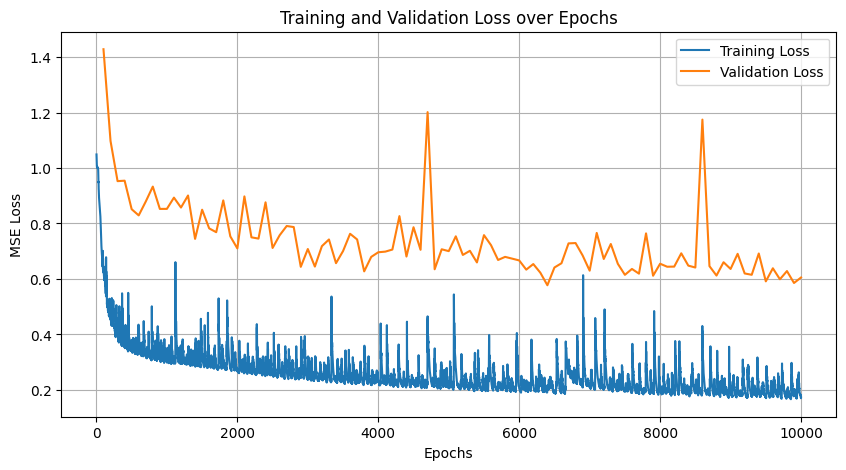

0.6051907539367676

In [ ]:
lr = 0.00455
num_layers = 14
hidden_size = 26

model = TrafficModel(input_size=X_train.shape[1], hidden_sizes=[hidden_size] * num_layers, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
            val_losses.append(val_loss.item())

print("Learning Rate: ",lr)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(100, len(train_losses) + 1, 100), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()
val_losses[-1]

In [ ]:
# Guardar todo el modelo
torch.save(model, 'congestion_model_full.pth')

In [ ]:
# # Crear el modelo de nuevo
# model = CongestionModel()

# # Cargar los pesos
# model.load_state_dict(torch.load('congestion_model.pth'))

In [ ]:
# # Establecer el modelo en modo de evaluación (importante para inferencia)
# model.eval()

# # Datos para predecir (hora, clima, tráfico pasado)
# new_data = np.array([[10, 0, 3]])  # Ejemplo: hora 10 AM, tráfico moderado

# # Convertir los datos a tensor de PyTorch
# new_data_tensor = torch.tensor(new_data, dtype=torch.float32)

# # Hacer predicciones
# with torch.no_grad():  # No calcular gradientes para la predicción
#     predicted_congestion = model(new_data_tensor)
#     print(f'Predicción de congestión: {predicted_congestion.item()}%')